In [1]:
!pip install git+https://github.com/desi-bgs/bgs-cmxsv.git --upgrade --user

  Cloning https://github.com/desi-bgs/bgs-cmxsv.git to /tmp/pip-req-build-bw42m0f5
  Running command git clone -q https://github.com/desi-bgs/bgs-cmxsv.git /tmp/pip-req-build-bw42m0f5
  Created wheel for bgs-sv: filename=bgs_sv-0.0-py3-none-any.whl size=1086844 sha256=8ea9e89f40e710007d3b181693600f3250c7b1b0179d527d4582a15db7ce9d23
  Stored in directory: /tmp/pip-ephem-wheel-cache-lfk9_z2n/wheels/c5/7b/33/3fa8f7338087a37e7ad7a1378e08d97458e5dbab577a10268f
Successfully built bgs-sv
  Attempting uninstall: bgs-sv
    Found existing installation: bgs-sv 0.0
    Uninstalling bgs-sv-0.0:
      Successfully uninstalled bgs-sv-0.0


In [2]:
import numpy as np 
import astropy.table as atable
import matplotlib.pyplot as plt

from bgs_sv import sv1

# read single exposures from Blanc reduction
Rongpu ran redrock on all of the Blanc exposures

In [3]:
exps = sv1.blanc_nexp1_exposures()

In [55]:
is_bgs = (exps['TARGETS'] == 'BGS+MWS') & (exps['GFA_TRANSPARENCY'] > 0.9) & (exps['GFA_FWHM_ASEC'] < 1.)
print('%i BGS exposures in Blanc with GFA TRANSP > 0.9 and FWHM < 1.1' % np.sum(is_bgs))
bgs_exps = exps[is_bgs]

27 BGS exposures in Blanc with GFA TRANSP > 0.9 and FWHM < 1


In [56]:
bgs_exps

NIGHT,EXPID,FIELD,TARGETS,OBSCONDITIONS,ARIZONA_TIMEOBS,EBV,SPECMODEL_SKY_GMAG_AB,SPECMODEL_SKY_RMAG_AB,SPECMODEL_SKY_ZMAG_AB,GFA_ORIGIN,B_DEPTH,R_DEPTH,Z_DEPTH,B_DEPTH_EBVAIR,R_DEPTH_EBVAIR,Z_DEPTH_EBVAIR,DAILY_BITPSFFN,DAILY_BITFRAMEFN,DAILY_BITSKYFN,DAILY_BITSFRAMEFN,DAILY_BITFLUXCALIBFN,DAILY_BITCFRAMEFN,TGT,SKY,STD,WD,LRG,ELG,QSO,BGS,MWS,TILEID,TILERA,TILEDEC,EXPTIME,MJDOBS,SKYMON_NEXP,SKYMON_SKYCAM0_MEAN,SKYMON_SKYCAM0_MEAN_ERR,SKYMON_SKYCAM1_MEAN,SKYMON_SKYCAM1_MEAN_ERR,SKYMON_AVERAGE_MEAN,SKYMON_AVERAGE_MEAN_ERR,GFA_AIRMASS,GFA_MOON_ILLUMINATION,GFA_MOON_ZD_DEG,GFA_MOON_SEP_DEG,GFA_TRANSPARENCY,GFA_FWHM_ASEC,GFA_SKY_MAG_AB,GFA_FIBER_FRACFLUX,GFA_FIBER_FRACFLUX_ELG,GFA_TRANSPFRAC,GFA_MAXCONTRAST,GFA_MINCONTRAST,GFA_KTERM,GFA_RADPROF_FWHM_ASEC,GFA_FIBERFAC,GFA_FIBERFAC_ELG,EPHEM_NOON,EPHEM_DUSK,EPHEM_DAWN,EPHEM_BRIGHTDUSK,EPHEM_BRIGHTDAWN,EPHEM_BRIGHTDUSK_LST,EPHEM_BRIGHTDAWN_LST,EPHEM_MOONRISE,EPHEM_MOONSET,EPHEM_MOON_ILLUM_FRAC,EPHEM_NEAREST_FULL_MOON
int64,int64,bytes30,bytes16,int16,bytes19,float32,float32,float32,float32,bytes13,float32,float32,float32,float32,float32,float32,int64,int64,int64,int64,int64,int64,int16,int16,int16,int16,int16,int16,int16,int16,int16,int64,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
20201218,68657,Lynx,BGS+MWS,1,2020-12-18T23:02:42,0.053,22.769003,21.796167,20.121853,matched_coadd,665.7,667.0,723.6,443.01218,511.81992,624.54456,1073741823,1073741823,1073741823,1073741823,1073741823,1073741823,4199,800,150,12,519,24,12,3279,919,80613,106.74,56.1,300.0,59202.25,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.235998,0.24195005,105.69245,129.81725,0.99107206,0.8323026,20.901247,0.7034661,0.49548486,0.6971856,15.700413,10.978629,0.114,0.88625854,1.2234991,1.19527,59201.791666666664,59202.07819552423,59202.53794256821,59202.05746491799,59202.55867547271,-2.8037748348945115,178.12604437096692,59201.74867241028,59202.201215020024,0.24614796278654827,10.852906347514363
20201218,68658,Lynx,BGS+MWS,1,2020-12-18T23:12:39,0.053,22.769278,21.77523,20.050707,matched_coadd,636.7,625.9,656.9,426.60165,481.89108,568.0628,1073741823,1073741823,1073741823,1073741823,1073741823,1073741823,4199,800,150,12,519,24,12,3279,919,80613,106.74,56.1,300.0,59202.258,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.2170839,0.2425683,107.69759,129.7488,0.9880288,0.85079074,20.92377,0.6932153,0.4901137,0.68491673,18.431526,10.5376,0.114,0.9031612,1.2053653,1.1810758,59201.791666666664,59202.07819552423,59202.53794256821,59202.05746491799,59202.55867547271,-2.8037748348945115,178.12604437096692,59201.74867241028,59202.201215020024,0.24614796278654827,10.852906347514363
20201218,68659,Lynx,BGS+MWS,1,2020-12-18T23:22:38,0.053,22.768105,21.74646,19.962906,matched_coadd,549.9,526.0,531.3,370.74045,406.2171,460.25452,1073741823,1073741823,1073741823,1073741823,1073741823,1073741823,4199,800,150,12,519,24,12,3279,919,80613,106.74,56.1,300.0,59202.266,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.1997856,0.24318741,109.711266,129.68033,0.9853296,0.90169716,20.797955,0.64931566,0.46314603,0.63978994,16.237127,10.631892,0.114,0.94517636,1.1376753,1.1218344,59201.791666666664,59202.07819552423,59202.53794256821,59202.05746491799,59202.55867547271,-2.8037748348945115,178.12604437096692,59201.74867241028,59202.201215020024,0.24614796278654827,10.852906347514363
20201218,68672,UMajor,BGS+MWS,1,2020-12-19T02:46:03,0.074,22.93675,21.561115,19.464235,matched_coadd,591.0,395.3,323.7,347.6061,278.2547,266.3863,1073741823,1073741823,1073741823,1073741823,1073741823,1073741823,4119,880,62,11,509,12,18,3084,1032,80619,144.0,65.0,300.0,59202.406,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1.2241184,0.25584742,150.43987,132.82948,0.98833865,0.9293999,20.725008,0.630266,0.45117745,0.6229163,11.761252,4.1200027,0.114,0.

In [57]:
# observing conditions from median value of the GFAs
airmass = bgs_exps['GFA_AIRMASS']
moon_frac = bgs_exps['GFA_MOON_ILLUMINATION']
moon_sep = bgs_exps['GFA_MOON_SEP_DEG']
moon_alt = 90. - bgs_exps['GFA_MOON_ZD_DEG']
transp = bgs_exps['GFA_TRANSPARENCY']

Now lets get sky surface brightness measurements for these exposures

In [58]:
# get sky surface brightnesses
Iskies = []
for i in np.arange(len(bgs_exps)):
    wave, Isky = sv1.get_obs_sky(int(bgs_exps[i]['NIGHT']), int(bgs_exps[i]['EXPID']), 'model', redux="daily");
    Iskies.append(Isky * 1e17)

In [59]:
# read in BGS reference sky brightness
f_reference = '/global/cfs/cdirs/desi/users/chahah/BGS_reference_sky_brightness.20210210.npy'
w_ref, Isky_ref = np.load(f_reference)

Text(0.5, 1.0, 'BGS ref. sky vs Blanc skies')

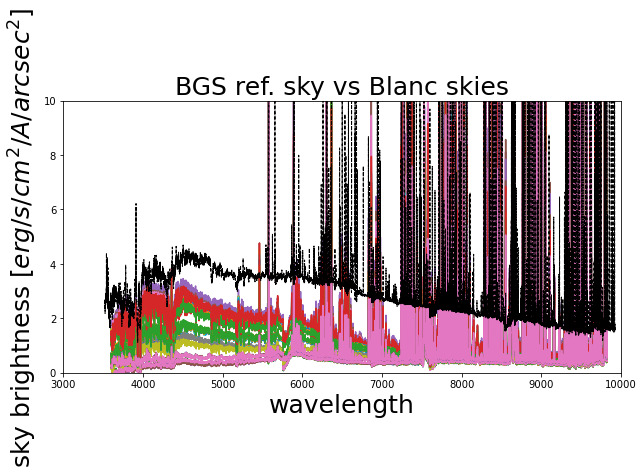

In [60]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)

for Isky in Iskies: 
    sub.plot(wave, Isky)

sub.plot(w_ref, Isky_ref, c='k', ls='--', lw=1, label='BGS reference sky')
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(3e3, 1e4)
sub.set_ylabel('sky brightness [$erg/s/cm^2/A/arcsec^2$]', fontsize=25)
sub.set_ylim(0., 10.)
sub.set_title('BGS ref. sky vs Blanc skies', fontsize=25)

**Blanc BGS exposures are all during conditions darker than the reference BGS sky.**

# caclulate $z$ success rate for nexp=1 expsoures using the deep exposures as the truth table

In [61]:
def zsuccess_redrock_criteria(zbest): 
    ''' redshift success criteria based only on redrock output
    '''
    crit_zwarn = (zbest['ZWARN'] == 0)
    crit_dchi2 = (zbest['DELTACHI2']  > 40.) 
    crit_stype = (zbest['SPECTYPE'] != "STAR") # only galaxy spectra
    crit_z_lim = (zbest['Z'] > 0.0) & (zbest['Z'] < 0.6) # rough BGS redshift limit
    crit_z_err = (zbest['ZERR'] < (0.0005 * (1. + zbest['Z'])))

    # combine all criteria
    zsuccess = crit_zwarn & crit_dchi2 & crit_stype & crit_z_lim & crit_z_err
    return zsuccess

def zsuccess_truth_criteria(zbest, z_true, silent=True): 
    ''' redshift success criteria based on redrock output *and* comparison
    to "true" redshift
    '''
    crit_zwarn = (zbest['ZWARN'] == 0)
    crit_dchi2 = (zbest['DELTACHI2']  > 40.) 
    crit_stype = (zbest['SPECTYPE'] != "STAR") # only galaxy spectra
    crit_z_lim = (zbest['Z'] > 0.0) & (zbest['Z'] < 0.6) # rough BGS redshift limit
    crit_z_err = (zbest['ZERR'] < (0.0005 * (1. + zbest['Z'])))
    
    dz_1pz = np.abs(z_true - zbest['Z']) / (1. + z_true)
    crit_ztrue = (dz_1pz < 0.003)

    # combine all criteria
    zsuccess = crit_zwarn & crit_dchi2 & crit_stype & crit_z_lim & crit_z_err & crit_ztrue
    if not silent: 
        print('%i of %i pass the redshift success criteria' % (np.sum(zsuccess), len(zsuccess)))
        print('%.2f redshift success rate' % (np.sum(zsuccess)/len(zsuccess)))
    return zsuccess

In [62]:
def zsuccess_rate(prop, zsuccess_cond, range=None, nbins=20, bin_min=2):
    ''' measure the redshift success rate along with property `prop`

    :params prop: 
        array of properties (i.e. Legacy r-band magnitude) 

    :params zsuccess_cond:
        boolean array indicating redshift success 

    :params range: (default: None) 
        range of the `prop` 

    :params nbins: (default: 20) 
        number of bins to divide `prop` by 
    
    :params bin_min: (default: 2)  
        minimum number of objects in bin to exlcude it 

    :return wmean: 
        weighted mean of `prop` in the bins 

    :return e1: 
        redshift success rate in the bins

    :return ee1: 
        simple poisson error on the success rate
    '''
    h0, bins = np.histogram(prop, bins=nbins, range=range)
    hv, _ = np.histogram(prop, bins=bins, weights=prop)
    h1, _ = np.histogram(prop[zsuccess_cond], bins=bins)
    
    good = h0 > bin_min
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    wmean = hv / h0 # weighted mean 
    rate = h1.astype("float") / (h0.astype('float') + (h0==0))
    e_rate = np.sqrt(rate * (1 - rate)) / np.sqrt(h0.astype('float') + (h0 == 0))
    return wmean, rate, e_rate

In [63]:
def get_exp_rmag_zsucess(tileid, night, expid): 
    # only use BRIGHT + FAINT targets where we have accurate redshifts in the deep exposure
    _zbest_deep = sv1.get_zbest(tileid, 'deep', targetclass='brightfaint')
    zs_deep = zsuccess_redrock_criteria(_zbest_deep)

    zbest_deep = _zbest_deep[zs_deep]['TARGETID', 'Z']
    zbest_deep.rename_column('Z', 'Z_TRUE') # deep exposure redshift is the "true redshift"
    
    _zbest_exp = sv1.get_zbest(tileid, night, expid=expid, targetclass='brightfaint')
    zbest_exp = atable.join(zbest_deep, _zbest_exp, keys='TARGETID', join_type='left')
    
    r_mag = 22.5 - 2.5 * np.log10(zbest_exp['FLUX_R']) 
    # calculate redshift successs rate
    return r_mag, zsuccess_truth_criteria(zbest_exp, zbest_exp['Z_TRUE'])

In [64]:
r_mags, zs_exps = [], [] 
for tid, n, eid in zip(bgs_exps['TILEID'], bgs_exps['NIGHT'], bgs_exps['EXPID']): 
    r_mag, zs_exp = get_exp_rmag_zsucess(tid, n, eid)
    r_mags.append(r_mag)
    zs_exps.append(zs_exp)

In [65]:
# first lets install the python package `feasibgs`, a python package for the BGS spectral simulations
!pip install git+https://github.com/desi-bgs/feasiBGS.git --upgrade --user

  Cloning https://github.com/desi-bgs/feasiBGS.git to /tmp/pip-req-build-w2zubqag
  Running command git clone -q https://github.com/desi-bgs/feasiBGS.git /tmp/pip-req-build-w2zubqag
  Created wheel for feasibgs: filename=feasibgs-0.1-py3-none-any.whl size=47422 sha256=e46596935f6bbb7125d81868c8c6a2e6192a5dfaf7902b8cc76dc2dcdb2575d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-ffscyz8r/wheels/f7/d7/9d/824c3b88b5bd8c28b8c576f20984e3cf31a80def7e3deae10a
Successfully built feasibgs
  Attempting uninstall: feasibgs
    Found existing installation: feasibgs 0.1
    Uninstalling feasibgs-0.1:
      Successfully uninstalled feasibgs-0.1


In [66]:
from feasibgs import spectral_sims as BGS_spec_sim
from feasibgs import util as UT
import fitsio

In [67]:
# read in source wavelength, flux, and galaxy properties. 
wave_s, flux_s, prop = BGS_spec_sim.simulated_GAMA_source_spectra(emlines=True)

# extract true redshift and r-band magnitude for the simulated galaxies
ztrue_sim = prop['zred'] # redshift
r_mag_sim = prop['r_mag'] # Legacy Survey r mag

# read redrock output
frr = '/global/cfs/cdirs/desi/users/chahah/redrock.bgs_spectral_sim.new_bgs_ref_sky.texp300s.fits' 
rr = fitsio.read(frr)

# redshift success defined as |z_redrock - z_true|/(1+z_true) < 0.003 and ZWARN flag = 0 
zs_ref = UT.zsuccess(rr['Z'], ztrue_sim, rr['ZWARN'], deltachi2=rr['DELTACHI2'], min_deltachi2=40)
#zs_ref[r_mag_sim < 18.2] = True # this is to account for the unusual bright z failures, which we think will eventually be ironed out

Text(0, 0.5, '$z$ success rate')

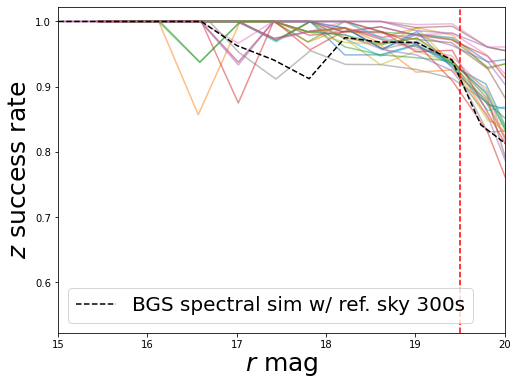

In [68]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

for r_mag, zs_exp in zip(r_mags, zs_exps):     
    r_mid, zs, zs_err = zsuccess_rate(r_mag, zs_exp, range=(14, 22), nbins=20)
    sub.plot(r_mid, zs, alpha=0.5)
r_mid, zs, zs_err = zsuccess_rate(r_mag_sim, zs_ref, range=(14, 22), nbins=20)
sub.plot(r_mid, zs, c='k', ls='--', label='BGS spectral sim w/ ref. sky 300s')
sub.legend(loc='lower left', fontsize=20)
sub.axvline(19.5, c='r', ls='--')
sub.set_xlabel('$r$ mag', fontsize=25)
sub.set_xlim(15, 20)
sub.set_ylabel('$z$ success rate', fontsize=25)

In [69]:
zs_19p5_ref = np.sum(zs_ref[r_mag_sim <= 19.5])/np.sum(r_mag_sim <= 19.5)
zs_19p5, zs_20p0 = [], []
for r_mag, zs_exp in zip(r_mags, zs_exps):
    zs_19p5.append(np.sum(zs_exp[r_mag <= 19.5])/np.sum(r_mag <= 19.5))
    zs_20p0.append(np.sum(zs_exp[r_mag <= 20.0])/np.sum(r_mag <= 20.0))

In [70]:
print('BGS spectral sim w/ reference')
print('redshift success rate r < 19.5 = %.3f' % zs_19p5_ref)
print('Blanc BGS exposures')
print('redshift success rate r < 19.5 = %.3f' % np.median(zs_19p5))
print('redshift success rate r < 20.0 = %.3f' % np.median(zs_20p0))

BGS spectral sim w/ reference
redshift success rate r < 19.5 = 0.964
Blanc BGS exposures
redshift success rate r < 19.5 = 0.970
redshift success rate r < 20.0 = 0.938


The spectral simulations are for AIRMASS = 1.1 and SEEING = 1.1. 

Good redshift success rates but again **Blanc BGS exposures are during conditions darker than the reference BGS sky.**